In [1]:
import numpy as np
import pandas as pd
import re
from vnlp import Normalizer
from vnlp import StopwordRemover
from vnlp import StemmerAnalyzer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from warnings import filterwarnings
filterwarnings("ignore")

# Feature Engineering

In [2]:
df=pd.read_csv("C:\\Users\\Dell\Desktop\\NLP\\sentimenty bot\\tweets_labeled.csv")
df.head()

,tweet_id,tweet,date,label
0,1606767075984375808,Berk Ali (kedim) seni çok özledim. Ölmek için ...,2022-12-24 21:41:37+00:00,1
1,1537178207677448193,"Yani, öylesine ciddiye alacaksın ki yaşamayı, ...",2022-06-15 21:00:18+00:00,1
2,1536458790802972673,saçlarının gölgesinde\nölmek ne güzeldi,2022-06-13 21:21:36+00:00,1
3,1495413883166760960,"Öyle güzel baktın ki, gözlerime\nsevmek değil ...",2022-02-20 15:03:47+00:00,1
4,1490420667614904334,sevmek biri için ölmek değil her şeye rağmen y...,2022-02-06 20:22:32+00:00,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12960 entries, 0 to 12959
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet_id  12960 non-null  int64 
 1   tweet     12959 non-null  object
 2   date      12960 non-null  object
 3   label     12960 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 405.1+ KB


In [4]:
df.isnull().sum()

tweet_id    0
tweet       1
date        0
label       0
dtype: int64

In [5]:
df[df["tweet"].isnull()]

,tweet_id,tweet,date,label
2472,1607240923053711360,NaN,2022-12-26 05:04:31+00:00,0


In [6]:
df.dropna(inplace=True)
df.isnull().sum()

tweet_id    0
tweet       0
date        0
label       0
dtype: int64

In [7]:
df["label"].value_counts()

label
 0    8448
-1    2904
 1    1607
Name: count, dtype: int64

In [8]:
df['tweet'].iloc[0:1].values

array(['Berk Ali (kedim) seni çok özledim. Ölmek için daha küçücüktün. Seni seviyorum oğlum ve hep sevicem.'],
      dtype=object)

In [9]:
df["date"]=pd.to_datetime(df["date"],utc=True)
df['date']=df['date'].dt.tz_convert('Europe/Istanbul')
df['date']=df['date'].dt.tz_localize(None)
df["day"]=df['date'].dt.dayofweek
df["month"]=df['date'].dt.month
df["hour"]=df['date'].dt.hour

seasons={12:"kış",1:"kış",2:"kış",3:"ilkbahar",4:"ilkbahar",5:"ilkbahar",6:"yaz",7:"yaz",8:"yaz",9:"sonbahar",10:"sonbahar",11:"sonbahar"}
df["season"]=df["month"].map(seasons)

hour_interval={22:"22-02",23:"22-02",0:"22-02",1:"22-02",
               2:"02-06",3:"02-06",4:"02-06",5:"02-06",
               6:"06-10",7:"06-10",8:"06-10",9:"06-10",
               10:"10-14",11:"10-14",12:"10-14",13:"10-14",
               14:"14-18",15:"14-18",16:"14-18",17:"14-18",
               18:"18-22",19:"18-22",20:"18-22",21:"18-22"}
df["hour_interval"]=df["hour"].map(hour_interval)

days={0:"pazartesi",1:"salı",2:"çarşamba",3:"perşembe",4:"cuma",5:"cumartesi",6:"pazar"}
df["day"]=df["day"].map(days)

In [10]:
df["label"].replace({1:"pozitif",0:"nötr",-1:"negatif"},inplace=True)

In [11]:
df.head()

,tweet_id,tweet,date,label,day,month,hour,season,hour_interval
0,1606767075984375808,Berk Ali (kedim) seni çok özledim. Ölmek için ...,2022-12-25 00:41:37,pozitif,pazar,12,0,kış,22-02
1,1537178207677448193,"Yani, öylesine ciddiye alacaksın ki yaşamayı, ...",2022-06-16 00:00:18,pozitif,perşembe,6,0,yaz,22-02
2,1536458790802972673,saçlarının gölgesinde\nölmek ne güzeldi,2022-06-14 00:21:36,pozitif,salı,6,0,yaz,22-02
3,1495413883166760960,"Öyle güzel baktın ki, gözlerime\nsevmek değil ...",2022-02-20 18:03:47,pozitif,pazar,2,18,kış,18-22
4,1490420667614904334,sevmek biri için ölmek değil her şeye rağmen y...,2022-02-06 23:22:32,pozitif,pazar,2,23,kış,22-02


In [12]:
df["tweet"].iloc[76:77].values

array(['00:00\nIyilige,huzura,mutluluğa,şansa,aşka 🍀🧿🌸🌺💃❤❤'], dtype=object)

            day      Ratio
day                       
cuma       1236  14.630682
pazar      1234  14.607008
salı       1231  14.571496
perşembe   1228  14.535985
pazartesi  1222  14.464962
çarşamba   1219  14.429451
cumartesi  1078  12.760417
---------------------------------------------


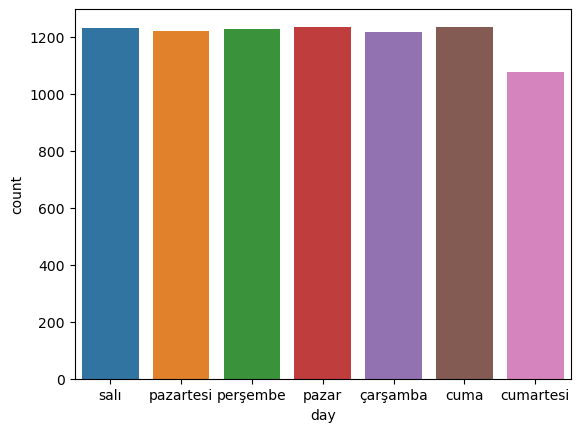

          season      Ratio
season                     
kış         2737  32.398201
sonbahar    2347  27.781723
yaz         1788  21.164773
ilkbahar    1576  18.655303
---------------------------------------------


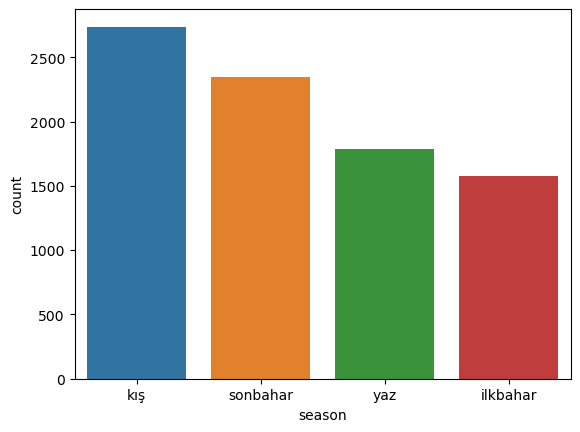

               hour_interval      Ratio
hour_interval                          
22-02                   3047  36.067708
18-22                   1819  21.531723
14-18                   1197  14.169034
10-14                   1122  13.281250
06-10                    750   8.877841
02-06                    513   6.072443
---------------------------------------------


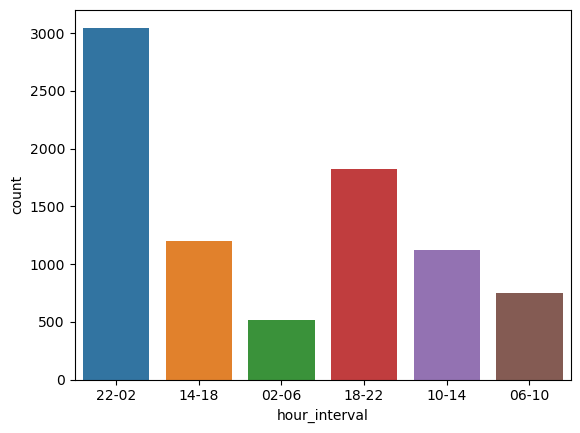

In [14]:
cols=["day","season","hour_interval"]

def summary(dataframe, col_name, plot=False):
    # negatif tweetler için hedef değişken analizi
    dataframe = dataframe.loc[df["label"] == "nötr"]
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("---------------------------------------------")

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

for col in cols:
    summary(df,col,plot=True)

# Prepare The Data And Logistic Regression

In [95]:
df["label"].replace({"pozitif":1,"nötr":0,"negatif":-1},inplace=True)

In [15]:
print(df["tweet"].iloc[76:77].values)
print(df["tweet"].iloc[23:24].values)

['00:00\nIyilige,huzura,mutluluğa,şansa,aşka 🍀🧿🌸🌺💃❤❤']
['Az once bugunun dogum gunum olmasiyla alakali depresif bir tweet aticaktim ama bir arkadasimin tam 00.00da attigi dogum gunun kutlu olsun mesajini gordum ve su an dunyanin en mutlu insaniyim, kucuk seylerin insani bu kadar mutlu edebilmesi inanilmaz']


In [16]:
stemmer = StemmerAnalyzer()
def word_stemmer(text):
    a=stemmer.predict(text)
    liste=[]
    for i in range(0,len(a)):
        b=a[i]
        liste.append(b[0:b.find("+")])
    return " ".join(i for i in liste)

In [99]:
normalizer = Normalizer()
stopword_remover = StopwordRemover()
df["tweet"]=df["tweet"].apply(lambda x: Normalizer.lower_case(str(x)))
df["tweet"]=df["tweet"].apply(lambda x: Normalizer.remove_accent_marks(str(x))) #vurgu işaretlerini kaldırıyor. 
#df["tweet"]=df["tweet"].apply(lambda x: Normalizer.remove_punctuations(str(x))) #noktalama işaretlerini kaldırıyor
df["tweet"]=df["tweet"].apply(lambda x: re.sub("[^a-zıöüşçğ]"," ",str(x))) #noktalama işaretlerini kaldırıyor
df["tweet"]=df["tweet"].apply(lambda x: " ".join(Normalizer.deasciify(str(x).split()))) # yazim -> yazım, dusunuyorum -> düşünüyorum 
df["tweet"]=df["tweet"].apply(lambda x: " ".join(normalizer.correct_typos(str(x).split()))) # yazım hatalarını düzeltme
df["tweet"]=df["tweet"].apply(lambda x: word_stemmer(x)) # kelime köklerine ayırma
df["tweet"]=df["tweet"].apply(lambda x: " ".join(stopword_remover.drop_stop_words(str(x).split()))) #stop words kelimerini kaldırma

In [19]:
print(df["tweet"].iloc[76:77].values)
print(df["tweet"].iloc[23:24].values)

['iyi huzur mutlu şans aşk']
['az bugün doğum gün ol alaka depresif bir tweet at bir arkadaş at doğum gün kutlu ol mesaj gör su an dünya mutlu insan küçük insan mutlu et inan']


In [115]:
#df.to_csv("C:\\Users\\Dell\Desktop\\NLP\\sentimenty bot\\prepared_data.csv",index=False)

In [18]:
df=pd.read_csv("C:\\Users\\Dell\Desktop\\NLP\\sentimenty bot\\prepared_data.csv")

In [20]:
temp_df=pd.Series(" ".join(df["tweet"]).split()).value_counts()
drops=temp_df[temp_df<=1]
df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in str(x).split() if x not in drops))
df.head()

,tweet_id,tweet,date,label,day,month,hour,season,hour_interval
0,1606767075984375808,berk al kedi özle öl küçücük sev oğul sevecim,2022-12-25 00:41:37,1,pazar,12,0,kış,22-02
1,1537178207677448193,yan öylesine ciddi al yaşa yet mesela zeytin d...,2022-06-16 00:00:18,1,perşembe,6,0,yaz,22-02
2,1536458790802972673,saç gölge öl güzel,2022-06-14 00:21:36,1,salı,6,0,yaz,22-02
3,1495413883166760960,öyle güzel bak göz sev öl gel iç,2022-02-20 18:03:47,1,pazar,2,18,kış,18-22
4,1490420667614904334,sev öl yaşa mis,2022-02-06 23:22:32,1,pazar,2,23,kış,22-02


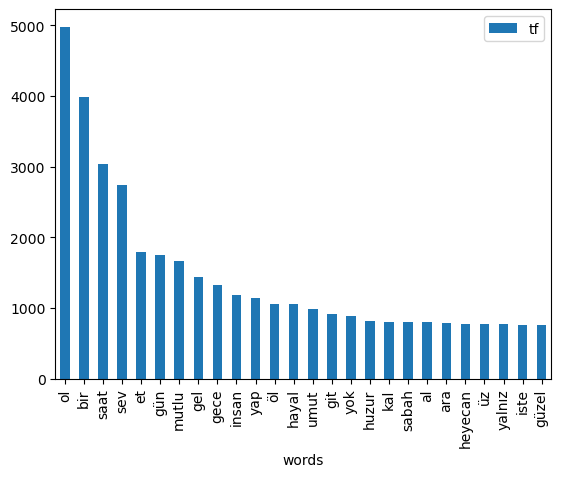

In [21]:
tf=pd.Series(" ".join(df["tweet"]).split()).value_counts()
tf=pd.DataFrame(tf)
tf.reset_index(inplace=True)
tf.columns=["words","tf"]
tf[tf["tf"]>750].plot.bar(x="words",y="tf")
plt.show()

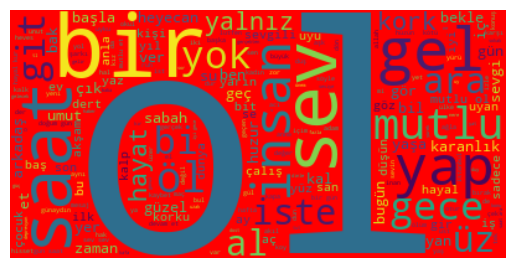

In [22]:
text=" ".join(i for i in df.tweet)
wordcloud=WordCloud(max_font_size=1000, max_words=1000, background_color="red").generate(text)
plt.figure()
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

In [23]:
y=df["label"]
X=df["tweet"]

In [24]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=14)

In [25]:
tf_idf_word_vectorizer=TfidfVectorizer().fit(x_train)
X_train=tf_idf_word_vectorizer.transform(x_train)
X_test=tf_idf_word_vectorizer.transform(x_test)

In [26]:
lr_model=LogisticRegression()
lr_model.fit(X_train,y_train)
cross_val_score(lr_model,
                X_train,
                y_train,
                scoring="accuracy",
                cv=5).mean()

0.70000804763081

In [27]:
y_pred=lr_model.predict(X_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

          -1       0.29      0.56      0.38       298
           0       0.92      0.71      0.80      2175
           1       0.26      0.72      0.38       119

    accuracy                           0.70      2592
   macro avg       0.49      0.67      0.52      2592
weighted avg       0.81      0.70      0.73      2592



# Sonuç